## Portfolio Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as data_reader
%matplotlib inline

In [2]:
symbols = ['AAPL', 'MSFT', 'YHOO', 'DB', 'GLD']
noa = len(symbols)

In [3]:
data = data_reader.DataReader(symbols, data_source='yahoo',
                               start='2015-01-01')['Adj Close']

/home/weiwu/.virtualenvs/data_analysis/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:334: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  SNIMissingWarning
/home/weiwu/.virtualenvs/data_analysis/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  Insecur

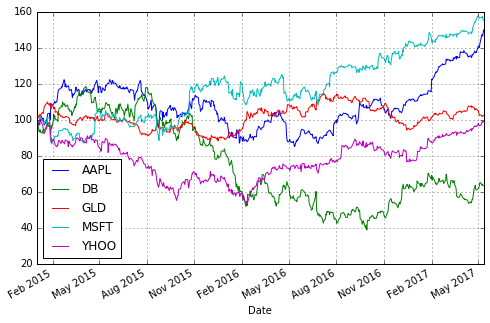

In [4]:
(data / data.ix[0] * 100).plot(figsize=(8, 5), grid=True)
# tag: portfolio_1
# title: Stock prices over time
# size: 90

In [5]:
rets = np.log(data / data.shift(1))

In [6]:
rets.mean() * 252

AAPL    0.171170
DB     -0.194698
GLD     0.010105
MSFT    0.186678
YHOO   -0.004420
dtype: float64

In [7]:
rets.cov() * 252

,AAPL,DB,GLD,MSFT,YHOO
AAPL,0.056952,0.025509,-0.004691,0.028088,0.022938
DB,0.025509,0.182353,-0.016000,0.032952,0.034075
GLD,-0.004691,-0.016000,0.021075,-0.005762,-0.003681
MSFT,0.028088,0.032952,-0.005762,0.056809,0.028853
YHOO,0.022938,0.034075,-0.003681,0.028853,0.081418


### The Basic Theory

In [8]:
weights = np.random.random(noa)
weights /= np.sum(weights)

In [9]:
weights

array([ 0.25225337,  0.28742585,  0.12815137,  0.32284958,  0.00931983])

In [10]:
np.sum(rets.mean() * weights) * 252
  # expected portfolio return

0.04873951057684272

In [11]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))
  # expected portfolio variance

0.0378492526229307

In [12]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
  # expected portfolio standard deviation/volatility

0.19454884379746568

In [13]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

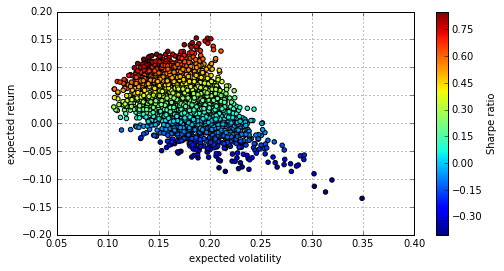

In [14]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
# tag: portfolio_2
# title: Expected return and volatility for different/random portfolio weights
# size: 90

###  Optimizations

In [15]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [16]:
import scipy.optimize as sco

In [17]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [18]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [19]:
bnds = tuple((0, 1) for x in range(noa))

In [20]:
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [21]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 159 ms


In [22]:
opts

     fun: -0.89964063622932411
     jac: array([  3.65152955e-05,   2.00167218e+00,  -1.04084611e-04,
         3.82214785e-05,   7.63027400e-01,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([  3.16847434e-01,   8.62049147e-16,   2.64774759e-01,
         4.18377806e-01,   0.00000000e+00])

In [23]:
opts['x'].round(3)

array([ 0.317,  0.   ,  0.265,  0.418,  0.   ])

In [24]:
statistics(opts['x']).round(3)

array([ 0.135,  0.15 ,  0.9  ])

In [25]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [27]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
optv

     fun: 0.010730271441493435
     jac: array([ 0.02170007,  0.0219665 ,  0.02134211,  0.02147932,  0.02160886,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 70
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.13088698,  0.06472664,  0.62765256,  0.1233222 ,  0.05341162])

In [28]:
optv['x'].round(3)

array([ 0.131,  0.065,  0.628,  0.123,  0.053])

In [29]:
statistics(optv['x']).round(3)

array([ 0.039,  0.104,  0.376])

#### comparison between minimum variance and maximum sharpe ratio
return, volatility, sharpe ratio
- maximum sharpe ratio
    array([ 0.135,  0.15 ,  0.9  ])
- minimum variance
    array([ 0.039,  0.104,  0.376])

### Efficient Frontier

In [30]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [31]:
def min_func_port(weights):
    return statistics(weights)[1]
# only return the variance

In [32]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 8.7 s, sys: 8 ms, total: 8.71 s
Wall time: 9.72 s


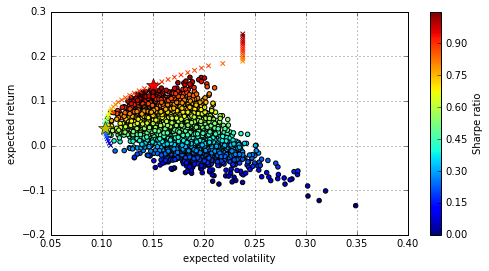

In [33]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x')
            # efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
# tag: portfolio_3
# title: Minimum risk portfolios for given return level (crosses)
# size: 90

### Capital Market Line

In [34]:
import scipy.interpolate as sci

In [94]:
ind = np.argmin(tvols)
evols = tvols[:-15]
erets = trets[:-15]
print len(evols)
print len(erets)
mask = np.in1d(erets, erets)
print np.where(mask)[0]
print np.where(~mask)[0]

35
35
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
[]


In [79]:
tvols

array([ 0.10887449,  0.10760964,  0.10650985,  0.10557955,  0.10482151,
        0.10424185,  0.10384268,  0.10362607,  0.10359318,  0.10374417,
        0.10407823,  0.10459365,  0.10528781,  0.10615684,  0.10719698,
        0.10840309,  0.10977003,  0.11143879,  0.11366075,  0.11641766,
        0.11967255,  0.12338602,  0.12751802,  0.13202925,  0.13688222,
        0.14204192,  0.14747614,  0.15315568,  0.15905425,  0.16514839,
        0.17141724,  0.17784232,  0.18440731,  0.19109779,  0.19790102,
        0.20480578,  0.21872766,  0.23834587,  0.23834587,  0.23834587,
        0.23834587,  0.23834587,  0.23834587,  0.23834587,  0.23834587,
        0.23834587,  0.23834587,  0.23834587,  0.23834587,  0.23834587])

In [80]:
np.argmin(tvols)

8

In [81]:
len(np.unique(trets))

50

In [82]:
tvols[ind:]

array([ 0.10359318,  0.10374417,  0.10407823,  0.10459365,  0.10528781,
        0.10615684,  0.10719698,  0.10840309,  0.10977003,  0.11143879,
        0.11366075,  0.11641766,  0.11967255,  0.12338602,  0.12751802,
        0.13202925,  0.13688222,  0.14204192,  0.14747614,  0.15315568,
        0.15905425,  0.16514839,  0.17141724,  0.17784232,  0.18440731,
        0.19109779,  0.19790102,  0.20480578,  0.21872766,  0.23834587,
        0.23834587,  0.23834587,  0.23834587,  0.23834587,  0.23834587,
        0.23834587,  0.23834587,  0.23834587,  0.23834587,  0.23834587,
        0.23834587,  0.23834587])

In [83]:
tck = sci.splrep(np.sort(tvols), np.sort(trets))

In [84]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

In [105]:
def equations(p, rf=0.0001):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [106]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

In [107]:
opt[0] + opt[1] * cx

array([  1.00000000e-04,   6.73795656e+01,   1.34759031e+02,
         2.02138497e+02,   2.69517963e+02,   3.36897428e+02,
         4.04276894e+02,   4.71656360e+02,   5.39035825e+02,
         6.06415291e+02,   6.73794756e+02,   7.41174222e+02,
         8.08553688e+02,   8.75933153e+02,   9.43312619e+02,
         1.01069208e+03,   1.07807155e+03,   1.14545102e+03,
         1.21283048e+03,   1.28020995e+03,   1.34758941e+03,
         1.41496888e+03,   1.48234834e+03,   1.54972781e+03,
         1.61710728e+03,   1.68448674e+03,   1.75186621e+03,
         1.81924567e+03,   1.88662514e+03,   1.95400460e+03,
         2.02138407e+03,   2.08876354e+03,   2.15614300e+03,
         2.22352247e+03,   2.29090193e+03,   2.35828140e+03,
         2.42566086e+03,   2.49304033e+03,   2.56041979e+03,
         2.62779926e+03,   2.69517873e+03,   2.76255819e+03,
         2.82993766e+03,   2.89731712e+03,   2.96469659e+03,
         3.03207605e+03,   3.09945552e+03,   3.16683499e+03,
         3.23421445e+03,

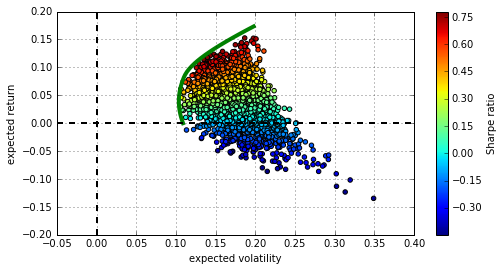

In [110]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o')
            # random portfolio composition
plt.plot(evols, erets, 'g', lw=4.0)
            # efficient frontier
cx = np.linspace(0.0, 0.3)
#plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
            # capital market line
#plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
# tag: portfolio_4
# title: Capital market line and tangency portfolio (star) for risk-free rate of 1%
# size: 90

In [111]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [112]:
res['x'].round(3)

array([ 0.136,  0.   ,  0.   ,  0.864,  0.   ])

In [113]:
res.jac

array([ 0.14303733,  0.14274265, -0.02509978,  0.23644911,  0.12535351,  0.        ])